In [1]:
from pathlib import Path
from urllib.request import urlretrieve

import gender_guesser.detector as gender
from bs4 import BeautifulSoup as Soup

In [2]:
detector = gender.Detector()
pycon_talks = {
    "py13_es": "http://2013.es.pycon.org/#agenda",
    "py14_es": "http://2014.es.pycon.org/talks",
    "py15_es": "http://2015.es.pycon.org/en/schedule/",
    "py16_es": "http://2016.es.pycon.org/en/schedule/",
    "py17_es": "https://2017.es.pycon.org/en/schedule/",
    "py18_es": "https://2018.es.pycon.org/#schedule",
    "py13_us": "https://us.pycon.org/2013/schedule/talks/list/",
    "py14_us": "https://us.pycon.org/2014/schedule/talks/list/",
    "py15_us": "https://us.pycon.org/2015/schedule/talks/list/",
    "py16_us": "https://us.pycon.org/2016/schedule/talks/",
    "py17_us": "https://us.pycon.org/2017/schedule/talks/",
    "py18_us": "https://us.pycon.org/2018/schedule/talks/",
}

In [3]:
def cleanup_names(names):
    devs = []
    for name in names:
        name = name.strip()
        if " " in name and not contains_junk(name):
            seperator = multiple_devs(name)
            if seperator is not None:
                for dev in name.split(seperator):
                    devs.append(dev.strip().title())
            else:
                name = name.replace("CodeSyntax - ", "")
                devs.append(name.title())
    return devs

In [4]:
def contains_junk(content):
    junk = ["pybonacci", ">", "#", "2016", "2017"]
    for j in junk:
        if j in content:
            return True
    return False

In [5]:
def get_soup(pycon):
    file = Path(f"{pycon}.html")
    if not file.exists():
        urlretrieve(pycon_talks[pycon], file)
    return Soup(file.read_text(), "html.parser")

In [6]:
def multiple_devs(names):
    seperators = [" and ", " e ", " y ", " / ", ", "]
    for seperator in seperators:
        if seperator in names:
            return seperator
    return None    

In [7]:
def pycon_article(pycon):
    soup = get_soup(pycon)
    schedule = soup.find("article", {"class": "schedule"})
    links = schedule.find_all("a")
    names = [link.text for link in links if "twitter" in link.get("href", "Nope")]
    return cleanup_names(names)

In [8]:
def pycon_header(pycon):
    soup = get_soup(pycon)
    schedule = soup.find("div", {"id": "onlytext"})
    headers = schedule.find_all("h1", {"class": "text-center"})
    names = [header.text.strip() for header in headers]
    return cleanup_names(names)

In [9]:
def pycon_ptag(pycon):
    soup = get_soup(pycon)
    schedule = soup.find("div", {"class": "container schedule"})
    names = [ptag.text for ptag in schedule.find_all("p") if ptag.find("strong")]
    return cleanup_names(names)

In [10]:
def pycon_div(pycon):
    soup = get_soup(pycon)
    schedule = soup.find("div", {"id": "schedule"})
    divs = schedule.find_all("div", {"class": "schedule__talk--speaker"})
    names = [div.text for div in divs]
    return cleanup_names(names)

In [11]:
def pycon_in_header(pycon):
    soup = get_soup(pycon)
    schedule = soup.find("div", {"class": "box-content"})
    headers = schedule.find_all("h4")
    names = [name.text.split(" in ")[0] for name in headers if " in " in name.text]
    return cleanup_names(names)

In [12]:
def pycon_speaker(pycon):
    soup = get_soup(pycon)
    schedule = soup.find_all("span", {"class": "speaker"})
    names = [speaker.text.strip() for speaker in schedule]
    return cleanup_names(names)

In [13]:
def classify_devs(devs, country=None, debug=False):
    gender_classes = {
        "andy": "unknown",
        "male": "male",
        "female": "female",
        "mostly_male": "male",
        "mostly_female": "female",
        "unknown": "unknown",
    }
    stats = dict()
    for dev in devs:
        gender = detector.get_gender(dev.split()[0], country)
        gen = gender_classes[gender]
        stats[gen] = stats.get(gen, 0) + 1
        stats["total"] = stats.get("total", 0) + 1
        if debug: print(f"[{gen}] {dev}")
    return stats

In [14]:
def percentage(pycon, target="female"):
    return round(pycon[target] / pycon['total'] * 100, 2)

In [15]:
py13_es = pycon_article("py13_es")
py14_es = pycon_header("py14_es")
py15_es = pycon_ptag("py15_es")
py16_es = pycon_ptag("py16_es")
py17_es = pycon_ptag("py17_es")
py18_es = pycon_div("py18_es")

In [16]:
py13_us = pycon_in_header("py13_us")
py14_us = pycon_in_header("py14_us")
py15_us = pycon_in_header("py15_us")
py16_us = pycon_speaker("py16_us")
py17_us = pycon_speaker("py17_us")
py18_us = pycon_speaker("py18_us")

In [17]:
p13_es = classify_devs(py13_es, "spain")
p14_es = classify_devs(py14_es, "spain")
p15_es = classify_devs(py15_es, "spain")
p16_es = classify_devs(py16_es, "spain")
p17_es = classify_devs(py17_es, "spain")
p18_es = classify_devs(py18_es, "spain")

In [18]:
p13_us = classify_devs(py13_us)
p14_us = classify_devs(py14_us)
p15_us = classify_devs(py15_us)
p16_us = classify_devs(py16_us)
p17_us = classify_devs(py17_us)
p18_us = classify_devs(py18_us)

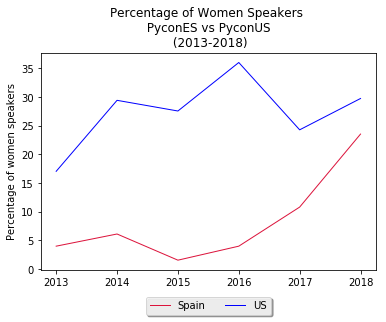

In [20]:
import matplotlib.pyplot as plt

year = [2013, 2014, 2015, 2016, 2017, 2018]
es = [
    percentage(p13_es),
    percentage(p14_es),
    percentage(p15_es),
    percentage(p16_es),
    percentage(p17_es),
    percentage(p18_es),
]
us = [
    percentage(p13_us),
    percentage(p14_us),
    percentage(p15_us),
    percentage(p16_us),
    percentage(p17_us),
    percentage(p18_us),
]

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(year, es, color="crimson", linewidth=1, label="Spain")
ax.plot(year, us, color="blue", linewidth=1, label="US")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), shadow=True, ncol=2)
# plt.plot(year, es, color="crimson", linewidth=1)
# plt.plot(year, us, color="blue", linewidth=1)
# plt.xlabel("Pycon")
plt.ylabel("Percentage of women speakers")
plt.title("Percentage of Women Speakers \n PyconES vs PyconUS \n (2013-2018)")
plt.show()